# Lecture 3) Classical Classification

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import auc

%matplotlib inline

import seaborn as sns #spezielle Graphikdarstellungen

pd.set_option("future.no_silent_downcasting", True)

In der Vorlesung haben wir 3 Verfahren zur Klassifikation kennengelernt:

- logistische Regression (hauptsächlich für Y mit 2 Merkmalen)
- Diskriminanzanalyse (Y mit mehreren Merkmalen)
- KNN

Die lineare Diskriminanzanalyse geht davon aus, daß die erklärenden Größen $X_i$ durch eine multivariate Normalverteilung mit $p$ unterschiedlichen Erwartungswerten $\mu_i$ im Vektor $\vec{\mu}=(\mu_1,...,\mu_p)$, aber gleicher Varianz beschrieben werden. Das heißt, wir haben lineare Entscheidungsgrenzen.

Erweiterung: Die quadratische Diskriminanzanalyse erlaubt auch verschiedene Varianzen. Die Entscheidungsgrenzen sind dann nicht-linear.

#### Bemerkung: jedes Regressionsproblem läßt sich in eine Klassifikationsaufgabe umformulieren indem man die Zielgröße in Bins einteilt. Die Anzahl der Klassen wird dann durch den Wertebereich und die Breite der Bins festgelegt!

Wir starten mit einer binären Klassifikation und einer erklärenden Größe.

## 3.1) Logistische Regression

...als erstes importieren wir die Daten. Die Zielgröße ist AHD (binär) = Herzinfarkt 'ja' oder 'nein'

In [11]:
Heart = pd.read_csv("../../data-sets/heart.csv")
len(Heart)

300

In [12]:
Heart.head()

,Unnamed: 0,Age,Sex,ChestPain,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,Thal,AHD
0,1,63,1,typical,145,233,1,2,150,0,2.3,3,0,fixed,No
1,2,67,1,asymptomatic,160,286,0,2,108,1,1.5,2,3,normal,Yes
2,3,67,1,asymptomatic,120,229,0,2,129,1,2.6,2,2,reversable,Yes
3,4,37,1,nonanginal,130,250,0,0,187,0,3.5,3,0,normal,No
4,5,41,0,nontypical,130,204,0,2,172,0,1.4,1,0,normal,No


Auswahl einiger relevanter (numerischer) erklärender Größen:

In [13]:
HeartBin=Heart[['Age','Sex','Chol','AHD']]
HeartBin.head()

,Age,Sex,Chol,AHD
0,63,1,233,No
1,67,1,286,Yes
2,67,1,229,Yes
3,37,1,250,No
4,41,0,204,No


mal überprüfen, daß es tatsächlich nur zwei Ausprägungen der Zielgröße AHD gibt:

In [14]:
print(HeartBin['AHD'].unique())

['No' 'Yes']


wie sind die Beispiele in den beiden Gruppen verteilt? Zahlenmäßig

In [15]:
print(HeartBin.groupby('AHD').size())

AHD
No     161
Yes    139
dtype: int64


die beiden Gruppen sind von ihrer Größe her ziemlich ausgeglichen. Das ist ganz gut, wir brauchen hier also nichts zu unternehmen.

Für die weiteren Arbeiten ersetzen wir mal die beiden Ausprägungen durch 1='Yes' und 0='No'

In [16]:
HeartBin=HeartBin.replace(['No', 'Yes'], [0,1]) 

In [17]:
HeartBin.head()

,Age,Sex,Chol,AHD
0,63,1,233,0
1,67,1,286,1
2,67,1,229,1
3,37,1,250,0
4,41,0,204,0


Vielleicht sieht man ja in der Graphik schon ob sich die beiden Gruppen leicht unterscheiden lassen:

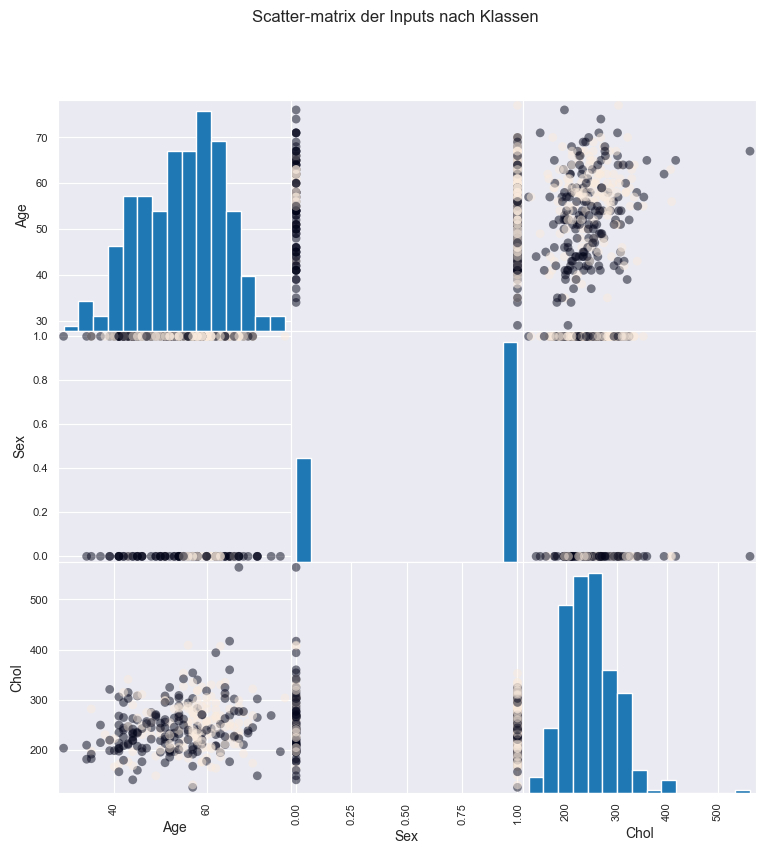

In [18]:
features_heart = ['Age', 'Sex', 'Chol']
Inputs = HeartBin[features_heart]
Target = HeartBin['AHD']

scatter = pd.plotting.scatter_matrix(Inputs, c = Target, marker = 'o', s=40, hist_kwds={'bins':15}, figsize=(9,9))
plt.suptitle('Scatter-matrix der Inputs nach Klassen')
plt.savefig('HeartBin_scatter_matrix.pdf')

nicht so klar, wir versuchen es aber trotzdem und verwenden zuerst nur den Cholesterinwert als Prädiktor.
Als erstes teilen wir den Datensatz in Trainings- und Testmenge. Dazu kann man den 

train_test_split 

von sklearn verwenden

In [19]:
from sklearn.model_selection import train_test_split

# 20% Testmenge

X_train, X_test, y_train, y_test = train_test_split(Inputs, Target, test_size=0.2)


X_train

,Age,Sex,Chol
146,41,1,250
83,68,1,274
82,39,1,321
29,40,1,167
295,57,0,241
...,...,...,...
278,58,0,197
298,57,1,131
123,65,1,282
55,54,1,266


In [20]:
X_train1=np.array(X_train).reshape(-1,3)
X_test1=np.array(X_test).reshape(-1,3)

Für die Klassifikation kann man z.B. die LogisticRegression aus sklearn verwenden:

In [21]:
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_curve, roc_auc_score, classification_report, accuracy_score, confusion_matrix 

In [22]:
y_train

146    0
83     1
82     0
29     1
295    1
      ..
278    0
298    1
123    1
55     1
81     0
Name: AHD, Length: 240, dtype: object

In [23]:
logistic_reg=LogisticRegression() # Modell spezifizieren
logistic_reg.fit(X_train1,y_train) # Modell fitten - Trainingsmenge

ValueError: Unknown label type: unknown. Maybe you are trying to fit a classifier, which expects discrete classes on a regression target with continuous values.

jetzt kann man sich die Wahrscheinlichkeiten für y=0 und y=1 ausgeben lassen. Dazu benutzt man die Funktion predict_proba

man bekommt ein array mit den Zugehörigkeitswahrscheinlichkeiten beider Klassen.  
Im einfachsten Fall gilt:  
$P(Y=1)=1-P(Y=0)$

In [74]:
yhat_tr_pr=logistic_reg.predict_proba(X_train1)[:,1]
yhat_test_pr=logistic_reg.predict_proba(X_test1)[:,1]
yhat_tr_pr

array([0.48932535, 0.73236681, 0.47791864, 0.57299768, 0.14037383,
       0.70428875, 0.41849553, 0.35248691, 0.3837809 , 0.62473394,
       0.44418467, 0.67095294, 0.64478051, 0.71829404, 0.41568256,
       0.33030865, 0.40610034, 0.62758517, 0.26534328, 0.55833454,
       0.52128506, 0.66297214, 0.72659769, 0.62929166, 0.48156741,
       0.22693707, 0.16001653, 0.14826931, 0.47442507, 0.21406431,
       0.18101345, 0.22704417, 0.5926891 , 0.60016546, 0.54674123,
       0.41036729, 0.2237482 , 0.18047237, 0.53236755, 0.56223561,
       0.44223056, 0.12691501, 0.72429271, 0.6376347 , 0.42265171,
       0.32726933, 0.53312523, 0.70454181, 0.48734744, 0.58280224,
       0.40683465, 0.24912757, 0.42294832, 0.63156198, 0.68214752,
       0.2647043 , 0.40692484, 0.54069701, 0.27733833, 0.24855813,
       0.45941796, 0.61425434, 0.46108251, 0.62373427, 0.5713581 ,
       0.62644573, 0.28908077, 0.44547952, 0.62144401, 0.12470482,
       0.49754618, 0.26163384, 0.60454166, 0.58413531, 0.25718

die tatsächlich Klasse müßte man sich dann mit dem entsprechenden threshold ausrechnen. Das geht "per hand" oder eben direkt mit predict

In [76]:
yhat_tr=logistic_reg.predict(X_train1) # Predictions Training
yhat_test=logistic_reg.predict(X_test1) # Predicitions Test
yhat_tr

array([0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1,
       0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1])

Die Trefferquote ist ein mögliches Maß für die Güte des Klassifikationsmodelles:

In [16]:
print(logistic_reg.score(X_train1,y_train)) # Trainingsmenge
print(logistic_reg.score(X_test1,y_test)) # Testmenge

0.6458333333333334
0.65


In [17]:
# auch aus der ROC-Curve kriegt man einen score mit Hilfe der AUC
# erstmal auf der Trainingsmenge

train_accuracy = accuracy_score(y_train, yhat_tr)*100
train_auc_roc = roc_auc_score(y_train, yhat_tr_pr)

print('Confusion matrix:\n', confusion_matrix(y_train, yhat_tr))

print('Training AUC: %.4f ' % train_auc_roc)

print('Training accuracy: %.4f %%' % train_accuracy)

Confusion matrix:
 [[87 39]
 [46 68]]
Training AUC: 0.7099 
Training accuracy: 64.5833 %


wichtig ist für uns jetzt aber eigentlich der Testfehler bzw. die Test-Accuracy

In [18]:
test_accuracy = accuracy_score(y_test, yhat_test)*100
test_auc_roc = roc_auc_score(y_test, yhat_test_pr)

print('Confusion matrix:\n', confusion_matrix(y_test, yhat_test))

print('Testing AUC: %.4f ' % test_auc_roc)

print('Testing accuracy: %.4f %%' % test_accuracy) 

Confusion matrix:
 [[23 12]
 [ 9 16]]
Testing AUC: 0.7440 
Testing accuracy: 65.0000 %


Die AUC ist nicht besonders toll. Optimal wäre 1!
0.5 liegt nahe am "Zufallsmodell"!
Das müßte man auch an der ROC-Curve sehen (nahe an der WH)

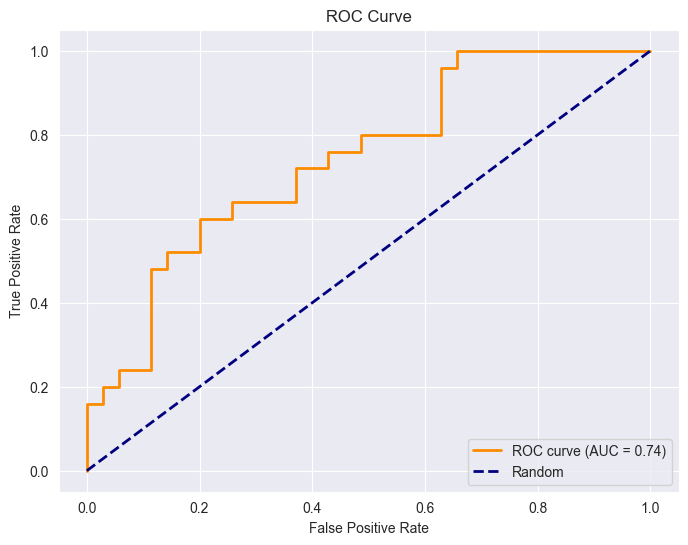

In [19]:
# Predict probabilities for the positive class
y_probs = logistic_reg.predict_proba(X_test1)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6));
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right');

Es gibt auch die Möglichkeit sich alle Performance-Maße in einem Report anzeigen zu lassen:

In [20]:
print(classification_report(y_test, yhat_test, digits=4))

              precision    recall  f1-score   support

           0     0.7188    0.6571    0.6866        35
           1     0.5714    0.6400    0.6038        25

    accuracy                         0.6500        60
   macro avg     0.6451    0.6486    0.6452        60
weighted avg     0.6574    0.6500    0.6521        60



### Aufgabe 1)

Die Qualität der Klassifikation mit nur einer erklärenden Größe läßt zu wünschen übrig!

Vielleicht verbessert sich das Ganze, wenn man die 2 anderen Variablen noch im Input berücksichtigt?

- Erweitern Sie das Klassifikationsmodell um die Größen 'Age' und 'Sex'
- Werten Sie für den Vergleich mit dem ersten, einfachen Modell geeignete Performance-Maße aus
- Momentan werden 80% der Daten zum Training und der Rest für den Test verwendet. Variieren Sie den Anteil der Testdaten zwischen 5 und 50 % und lassen sie sich den Trainings- und den Testfehler ausgeben.
- Stellen Sie das Ergebnis in einer Graphik dar (Anteil test: x-Achse, Train-Test Accuracy: y-Achse)

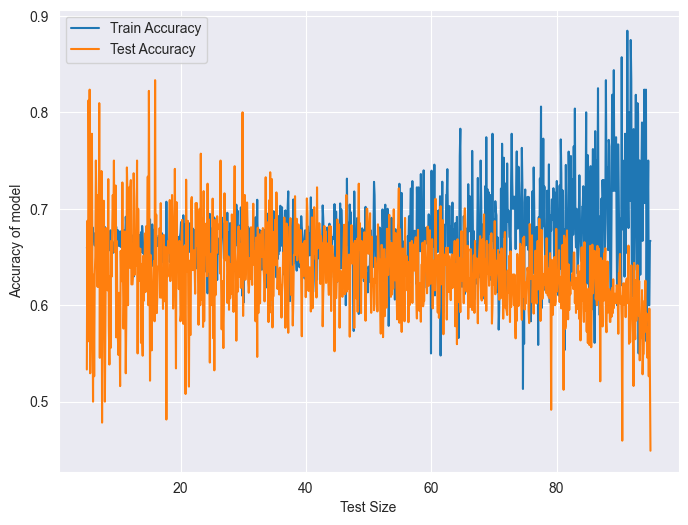

In [157]:
full_heart = pd.read_csv("../../data-sets/heart.csv")
heart = full_heart[["Age", "Sex", "Chol", "AHD"]]
heart = heart.replace(['No', 'Yes'], [0,1])
heart.head()

features = ["Age", "Sex", "Chol"]

inputs = heart[features]
target = heart["AHD"].astype(int)

indexes = []
train_accuracies = []
test_accuracies = []

for testing_size in np.linspace(0.05, 0.95, 1000):
     x_train, x_test, y_train, y_test = train_test_split(inputs, target, test_size=testing_size)
     
     x_train_reshaped = np.array(x_train).reshape(-1, len(features))
     x_test_reshaped = np.array(x_test).reshape(-1, len(features))
     
     logistic_reg = LogisticRegression()
     logistic_reg.fit(x_train_reshaped, y_train)
     
     y_hat_train = logistic_reg.predict(x_train_reshaped)
     y_hat_test = logistic_reg.predict(x_test_reshaped)
     
     train_accuracy = logistic_reg.score(x_train_reshaped, y_train)
     test_accuracy = logistic_reg.score(x_test_reshaped, y_test)
     
     train_accuracies.append(train_accuracy)
     test_accuracies.append(test_accuracy)
     indexes.append(testing_size*100)

plt.figure(figsize=(8, 6))
plt.plot(indexes, train_accuracies, label="Train Accuracy")
plt.plot(indexes, test_accuracies, label="Test Accuracy")
plt.xlabel("Test Size")
plt.ylabel("Accuracy of model")
plt.legend()
plt.show()




Going from 5% to 95% instead, we can clearly see a trend here. With more data to train on, if the model doesn't have a lot of data to train on, the accuracy can be all over the place, anywhere from 50% to 90% (in our case)

At about 50% training data, the model is the most consistent at about 60% accuracy. The more we increase the training data, however, the lower the accuracy seems to go. This can be due to the classification getting stricter on the training data, so it classifies them well, but when presented with new data, it classifies them poorly.

## 4.2) Klassifikation mit Hilfe der LDA

In der Vorlesung wurde die lineare Diskriminanzanalyse für die Klassifikation vorgestellt.
Damit lassen sich auch Aufgaben mit mehreren Ausprägungen der Zielgröße sehr gut bearbeiten.

Datensatz: Klassifikation von Früchten

In [1]:
Fruits = pd.read_csv("../../data-sets/Fruits.csv")
len(Fruits)
Fruits.head()


NameError: name 'pd' is not defined

In [23]:
print(Fruits['fruit_name'].unique())

['apple' 'mandarin' 'orange' 'lemon']


In [24]:
print(Fruits.groupby('fruit_name').size())

fruit_name
apple       19
lemon       16
mandarin     5
orange      19
dtype: int64


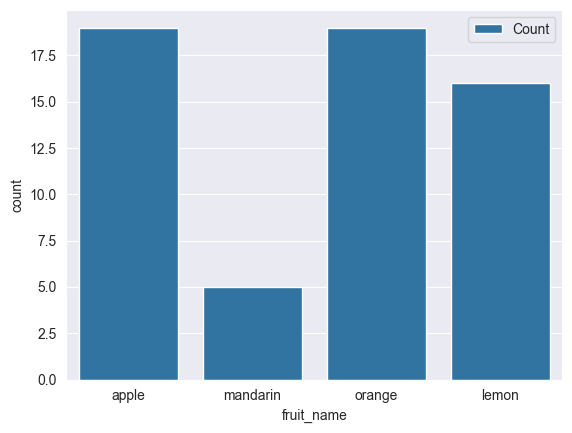

In [25]:

sns.countplot(x='fruit_name', data=Fruits, label="Count");


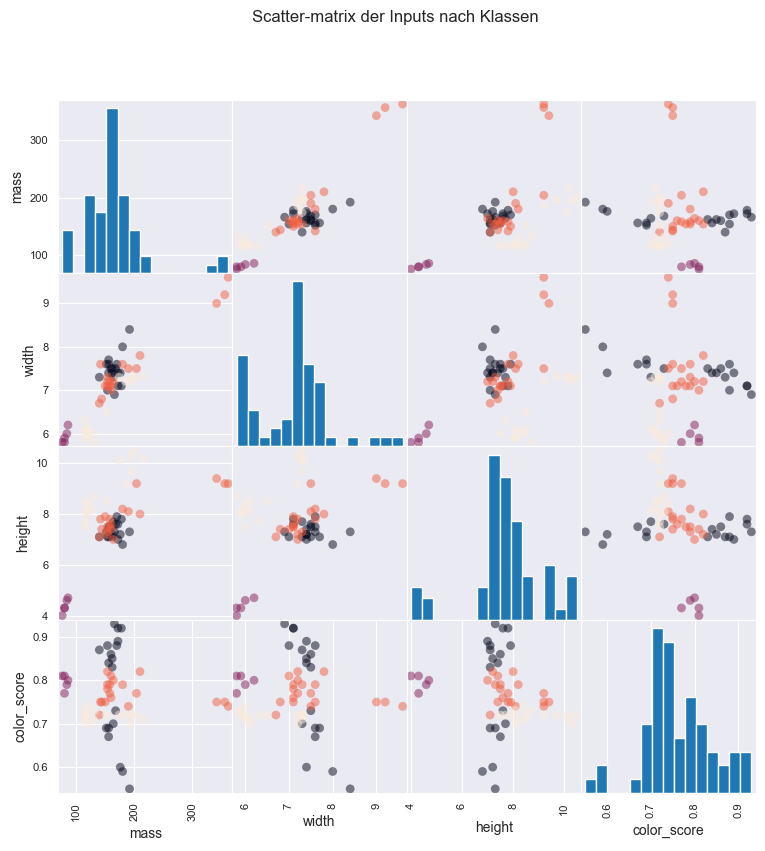

In [26]:

feature_names = ['mass', 'width', 'height', 'color_score']
X = Fruits[feature_names]
y = Fruits['fruit_label']

scatter = pd.plotting.scatter_matrix(X, c = y, marker = 'o', s=40, hist_kwds={'bins':15}, figsize=(9,9))
plt.suptitle('Scatter-matrix der Inputs nach Klassen')
plt.savefig('Fruits_scatter_matrix.pdf')


Jetzt teilen wir die Daten in Trainings- und Testmenge auf und bringen die Wertebereiche der unterschiedlichen Größen mit Hilfe einer Skalierung in Übereinstimmung. Das macht die Schätzung der Parameter in den verschiedenen Modellen wesentlich stabiler.

Man kann dazu z.B. einen

MinMaxScaler

verwenden. Dabei wird wie folgt skaliert:

X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
X_scaled = X_std * (max - min) + min

Damit liegen die Werte der $X_i, (i=1,...,p)$ nachher alle zwischen 0 und 1. 

In [9]:
InputsF = Fruits[feature_names]
TargetF = Fruits['fruit_label']

XF_train, XF_test, yF_train, yF_test = train_test_split(InputsF, TargetF, test_size=0.2, shuffle=True)

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
XF_train = scaler.fit_transform(XF_train)
XF_test = scaler.transform(XF_test)

XF_test

NameError: name 'Fruits' is not defined

Als Vergleich verwenden wir die logistische Regression (einfachstes Modell):

In [205]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(XF_train, yF_train)
print('Accuracy of Logistic regression classifier on training set: {:.2f}'
     .format(logreg.score(XF_train, yF_train)))
print('Accuracy of Logistic regression classifier on test set: {:.2f}'
     .format(logreg.score(XF_test, yF_test)))

Accuracy of Logistic regression classifier on training set: 0.68
Accuracy of Logistic regression classifier on test set: 0.50


Das ist natürlich nicht der Hit. Man kann vermuten, daß die lineare Diskriminanzanalyse ein besseres Ergebnis liefert.
Zur Erinnerung: die Mittelwerte werden auf den einzelnen Klassen separat ausgewertet, die Varianzen werden als gleich angenommen.
Wir haben lineare Entscheidungsgrenzen zwischen den Gruppen (im Gegensatz zur quadratischen Diskriminanzanalyse bei der es nicht-lineare Entscheidungsgrenzen gibt).

In sklearn sind beide Methoden implementiert.

## Lineare Diskriminanzanalyse

In [212]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# Modell definieren und fitten (Trainingsmenge)
lda = LDA()
lda.fit(XF_train, yF_train)

# Predicition für die Trainings- und Testmenge
yhat_tr_lda=lda.predict(XF_train)
yhat_test_lda=lda.predict(XF_test)

# Prognose Training
yhat_tr_lda

array([3, 1, 2, 4, 3, 1, 4, 4, 3, 3, 3, 4, 1, 1, 3, 2, 1, 1, 1, 3, 1, 1,
       3, 4, 3, 3, 4, 1, 1, 1, 4, 4, 1, 2, 4, 4, 3, 4, 1, 1, 1, 4, 4, 2,
       2, 1, 3])

In [213]:
# Accuracy auf der Trainings- und Testmenge

print(lda.score(XF_train, yF_train))
print(lda.score(XF_test, yF_test))

0.851063829787234
0.8333333333333334


In [232]:
# Confusion Matrix für den besseren Überblick

print('Confusion matrix (Train):\n', confusion_matrix(yhat_tr_lda, yF_train))
print('Confusion matrix (Test):\n', confusion_matrix(yhat_test_lda, yF_test))

Confusion matrix (Train):
 [[13  0  4  0]
 [ 0  5  0  0]
 [ 3  0  9  0]
 [ 0  0  0 13]]
Confusion matrix (Test):
 [[3 1 0]
 [0 4 0]
 [0 1 3]]


In [32]:
print(classification_report(yhat_test_lda, yF_test, digits=4))

              precision    recall  f1-score   support

           1     0.5000    0.5000    0.5000         4
           3     0.6000    0.6000    0.6000         5
           4     1.0000    1.0000    1.0000         3

    accuracy                         0.6667        12
   macro avg     0.7000    0.7000    0.7000        12
weighted avg     0.6667    0.6667    0.6667        12



### Aufgabe 2)

Wir haben für den ersten Versuch einfach mal alle Features ins Modell gesteckt.

- Untersuchen Sie, ob wir Kollinearität innerhalb der erklärenden Größen haben
- Nehmen Sie nur Größen ins Modell, die nicht zu sehr korrelieren
- Verbessert sich das Klassifikationsergebnis?

We have a high collinearity betwen `width` and `mass`, therefore we leave `width` out, and see if the classification improves

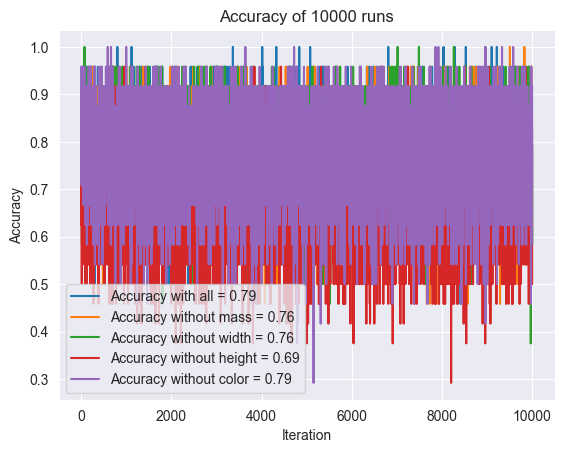

In [256]:
fruits = pd.read_csv("../../data-sets/Fruits.csv")

repetitions = 1000

features = ["mass", "width", "height", "color_score"]

x = fruits[features]
y = fruits["fruit_label"]

accuracies_all_attributes = []
for i in range(repetitions):
     x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, shuffle=True)
     
     scaler = MinMaxScaler()
     x_train = scaler.fit_transform(x_train)
     x_test = scaler.transform(x_test)
     
     lda = LDA()
     lda.fit(x_train, y_train)
     
     y_hat_train = lda.predict(x_train)
     y_hat_test = lda.predict(x_test)
     
     accuracies_all_attributes.append(lda.score(x_test, y_test))
     

features = ["width", "height", "color_score"]

x = fruits[features]
y = fruits["fruit_label"]

accuracies_no_mass = []
for i in range(repetitions):
     x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, shuffle=True)
     
     scaler = MinMaxScaler()
     x_train = scaler.fit_transform(x_train)
     x_test = scaler.transform(x_test)
     
     lda = LDA()
     lda.fit(x_train, y_train)
     
     y_hat_train = lda.predict(x_train)
     y_hat_test = lda.predict(x_test)
     
     accuracies_no_mass.append(lda.score(x_test, y_test))
     
features = ["width", "height", "color_score"]

x = fruits[features]
y = fruits["fruit_label"]

accuracies_no_width = []
for i in range(repetitions):
     x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, shuffle=True)
     
     scaler = MinMaxScaler()
     x_train = scaler.fit_transform(x_train)
     x_test = scaler.transform(x_test)
     
     lda = LDA()
     lda.fit(x_train, y_train)
     
     y_hat_train = lda.predict(x_train)
     y_hat_test = lda.predict(x_test)
     
     accuracies_no_width.append(lda.score(x_test, y_test))

features = ["mass", "width", "color_score"]

x = fruits[features]
y = fruits["fruit_label"]
     
accuracies_no_height = []
for i in range(repetitions):
     x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, shuffle=True)
     
     scaler = MinMaxScaler()
     x_train = scaler.fit_transform(x_train)
     x_test = scaler.transform(x_test)
     
     lda = LDA()
     lda.fit(x_train, y_train)
     
     y_hat_train = lda.predict(x_train)
     y_hat_test = lda.predict(x_test)
     
     accuracies_no_height.append(lda.score(x_test, y_test))
     
features = ["mass", "width", "height"]

x = fruits[features]
y = fruits["fruit_label"]
     
accuracies_no_color = []
for i in range(repetitions):
     x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, shuffle=True)
     
     scaler = MinMaxScaler()
     x_train = scaler.fit_transform(x_train)
     x_test = scaler.transform(x_test)
     
     lda = LDA()
     lda.fit(x_train, y_train)
     
     y_hat_train = lda.predict(x_train)
     y_hat_test = lda.predict(x_test)
     
     accuracies_no_color.append(lda.score(x_test, y_test))
     
plt.plot(accuracies_all_attributes, label=f"Accuracy with all = {np.mean(accuracies_all_attributes):.2f}")
plt.plot(accuracies_no_mass, label=f"Accuracy without mass = {np.mean(accuracies_no_mass):.2f}")
plt.plot(accuracies_no_width, label=f"Accuracy without width = {np.mean(accuracies_no_width):.2f}")
plt.plot(accuracies_no_height, label=f"Accuracy without height = {np.mean(accuracies_no_height):.2f}")
plt.plot(accuracies_no_color, label=f"Accuracy without color = {np.mean(accuracies_no_color):.2f}")
plt.title(f"Accuracy of {repetitions} runs")
plt.xlabel("Iteration")
plt.ylabel(f"Accuracy")
plt.legend()
plt.show()


We can clearly see that the average accuracy of the model has gone down the most by about 10% after leaving out `height`. Leaving out either `mass` or `width` reduced the accuracy by about 3%, and surprisingly, leaving out `color_score` did not affect the accuracy. (also, the test took 1.5 minutes for 10k iterations, so reduce the `iterations` variable in the above cell to run it)

## Quadratische Diskriminanzanalyse

In [2]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

In [34]:
# Modell definieren und fitten (Trainingsmenge)
qda = QDA()
qda.fit(XF_train, yF_train)

# Predicition für die Trainings- und Testmenge
yhat_tr_qda=qda.predict(XF_train)
yhat_test_qda=qda.predict(XF_test)

# Prognose Training
yhat_tr_qda

array([2, 1, 3, 1, 1, 3, 1, 3, 4, 4, 1, 4, 3, 2, 1, 2, 1, 1, 1, 2, 3, 4,
       1, 4, 3, 3, 4, 4, 1, 1, 1, 3, 3, 3, 1, 4, 1, 2, 1, 1, 4, 4, 1, 4,
       4, 3, 4])

Die Kollinearität von Input-Features macht das Fitten des Modelles instabil.
Daher gibt es auch die Warning.
Wir müßten uns also nachher sinnvollerweise darum kümmern nur Features als Input zu verwenden, die nicht zu stark korreliert sind.
Das machen wir dann später...

Erstmal verwenden wir das Modell wie es ist und werten aus:

In [35]:
# Accuracy auf der Trainings- und Testmenge

print(qda.score(XF_train, yF_train))
print(qda.score(XF_test, yF_test))

0.9361702127659575
0.8333333333333334


In [36]:
# Confusion Matrix für den besseren Überblick

print('Confusion matrix (Train):\n', confusion_matrix(yhat_tr_qda, yF_train))
print('Confusion matrix (Test):\n', confusion_matrix(yhat_test_qda, yF_test))

Confusion matrix (Train):
 [[15  0  3  0]
 [ 0  5  0  0]
 [ 0  0 11  0]
 [ 0  0  0 13]]
Confusion matrix (Test):
 [[4 2 0]
 [0 3 0]
 [0 0 3]]


es gibt eine Klasse für die im Training kein Beispiel richtig gelandet ist, nämlich die Klasse mit dem Label 2.
Das macht beim Auswerten natürlich ein bißchen Ärger (teilen durch 0!).
Die Confusion Matrix verrät uns aber woher das Problem kommt...

In [37]:
print(classification_report(yhat_test_qda, yF_test, digits=4))

              precision    recall  f1-score   support

           1     1.0000    0.6667    0.8000         6
           3     0.6000    1.0000    0.7500         3
           4     1.0000    1.0000    1.0000         3

    accuracy                         0.8333        12
   macro avg     0.8667    0.8889    0.8500        12
weighted avg     0.9000    0.8333    0.8375        12



### Aufgabe 3)

- Nehmen Sie nur Größen ins Modell, die nicht zu sehr korrelieren
- Verändern Sie die Auswahl der zum Training und Test verwendeten Daten-Samples. Variieren Sie die Größe der Testmenge zwischen 10% und 50% 
- Wie stabil ist das Ergebnis?

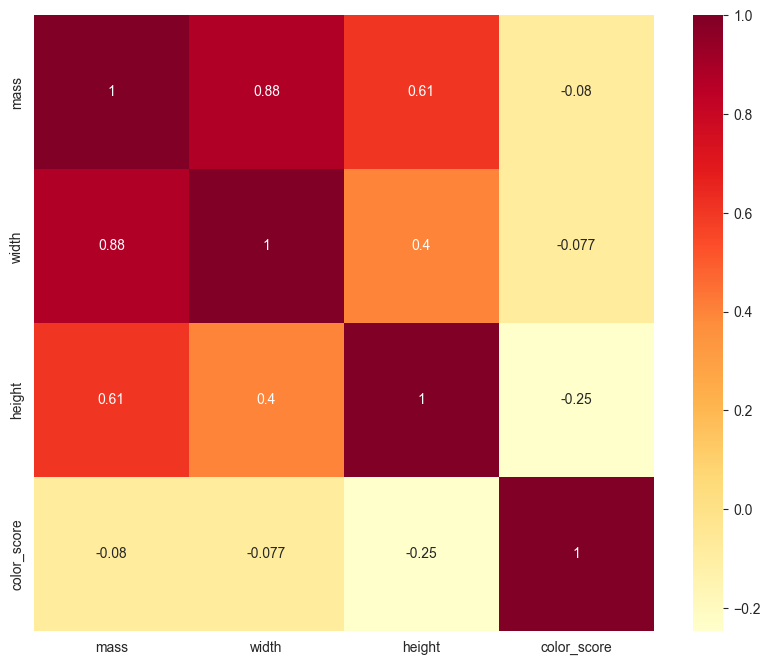

In [259]:
fruits = pd.read_csv("../../data-sets/Fruits.csv")
features = ["mass", "width", "height", "color_score"]
x = fruits[features]

fig = plt.figure(figsize=(10, 8));
sns.heatmap(x.corr(), cmap="YlOrRd", annot=True)
  
plt.show()

Here we can see that `color_score` has the smallest correlation across the board, and it seems to correlate the least with `width` (closest to 0), so we will use these two for our model.

C:\Users\filip\PycharmProjects\ML-Project\.venv\Lib\site-packages\sklearn\discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\filip\PycharmProjects\ML-Project\.venv\Lib\site-packages\sklearn\discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\filip\PycharmProjects\ML-Project\.venv\Lib\site-packages\sklearn\discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\filip\PycharmProjects\ML-Project\.venv\Lib\site-packages\sklearn\discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\filip\PycharmProjects\ML-Project\.venv\Lib\site-packages\sklearn\discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\filip\PycharmProjects\ML-Project\.venv\Lib\site-packages\sklearn\discri

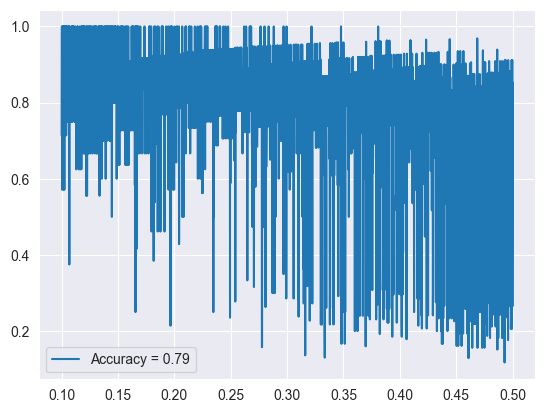

In [83]:
fruits = pd.read_csv("../../data-sets/Fruits.csv")

repetitions = 3000

features = ["width", "color_score", "height", "mass"]

x = fruits[features]
y = fruits["fruit_label"]

accuracies = []
indexes = []
for i in np.linspace(0.1, 0.5, repetitions):
     x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=i, shuffle=True)
     
     scaler = MinMaxScaler()
     x_train = scaler.fit_transform(x_train)
     x_test = scaler.transform(x_test)
     
     qda = QDA()
     qda.fit(x_train, y_train)
     
     y_hat_train = qda.predict(x_train)
     y_hat_test = qda.predict(x_test)
     
     accuracies.append(qda.score(x_test, y_test))
     indexes.append(i)
     
plt.plot(indexes, accuracies, label=f"Accuracy = {np.mean(accuracies):.2f}")
plt.legend()
plt.show()
     

Increasing the test size decreases the accuracy in this scenario. Though this could be due to the dataset being very small.

That said, the result is not consistent at all, as the accuracy goes from a range of 50% - 100% to a 10% - 90%. Again, likely caused because the dataset is too small (I had to augment the dataset and I added couple of "mandarin" datapoints, so that we don't get a case of underrepresented classes in training data)

## KNN (K-Nearest Neighbor) Klassifikation

Eine weitere Möglichkeit zur Klassifikation, die aber nicht im eigentlichen Sinn über ein Modell erfolgt ist der KNN-Algorithmus.

Dabei werden zwei Annahmen aufgestellt:

- näher beieinanderliegende Punkte sind ähnlich und gehören zur gleichen Klasse
- die Ähnlichkeit läßt sich durch eine sinnvolle Metrik (z.B. euklid. Abstand) messen

Die Vorhersage der Klasse für einen Punkt hängt dann nur von der Klasse der allernächsten Nachbarn ab!

Als Metaparameter muß man die Anzahl der zu untersuchenden nächsten Nachbarn festlegen, die dann auf Basis einer "Mehrheitsentscheidung" die Klasse für einen neuen Punkt festlegen.
Es ist auch möglich die umgebenden Punkte bei der Entscheidung gewichtet einfließen zu lassen.

Option

weights = 'uniform' # alle Punkte werden gleich gewichtet  
weights = 'distance' # Gewichtung mit dem Abstand

Mal ein Test mit der KNN-Funktion von sklearn...

In [38]:
from sklearn import neighbors


In [39]:
n_neighbors = 15 # Anzahl der berücksichtigten Punkte in einer Nachbarschaft

knnclf = neighbors.KNeighborsClassifier(n_neighbors, weights='uniform');
knnclf.fit(XF_train, yF_train);

In [40]:
# Predicition für die Trainings- und Testmenge
yhat_tr_knn=knnclf.predict(XF_train)
yhat_test_knn=knnclf.predict(XF_test)

# Prognose Training
yhat_tr_knn

array([3, 1, 3, 3, 1, 3, 1, 3, 4, 4, 3, 4, 3, 3, 3, 2, 1, 3, 3, 2, 3, 3,
       1, 3, 3, 4, 4, 4, 1, 3, 3, 3, 3, 3, 1, 4, 3, 2, 3, 1, 4, 3, 3, 3,
       3, 3, 3])

In [41]:
# Accuracy auf der Trainings- und Testmenge

print(knnclf.score(XF_train, yF_train))
print(knnclf.score(XF_test, yF_test))

0.6595744680851063
0.75


In [42]:
# Confusion Matrix für den besseren Überblick

print('Confusion matrix (Train):\n', confusion_matrix(yhat_tr_knn, yF_train))
print('Confusion matrix (Test):\n', confusion_matrix(yhat_test_knn, yF_test))

Confusion matrix (Train):
 [[ 8  0  0  0]
 [ 0  3  0  0]
 [ 7  2 13  6]
 [ 0  0  1  7]]
Confusion matrix (Test):
 [[3 0 0]
 [1 5 2]
 [0 0 1]]


In [43]:
print(classification_report(yhat_test_knn, yF_test, digits=4))

              precision    recall  f1-score   support

           1     0.7500    1.0000    0.8571         3
           3     1.0000    0.6250    0.7692         8
           4     0.3333    1.0000    0.5000         1

    accuracy                         0.7500        12
   macro avg     0.6944    0.8750    0.7088        12
weighted avg     0.8819    0.7500    0.7688        12



## Aufgabe 4)

Im Beispiel war die Gewichtung der Nachbarn bei der Entscheidung für alle gleich.

- Setzen Sie eine Abstandsgewichtung bei der Entscheidung ein. Verbessert sich das Ergebnis?

Für die Nachbarschaft wurden jeweils 15 Punkte berücksichtigt.

- Variieren Sie den Metaparameter 'n_neighbors' von 1 bis maximal und fertigen Sie eine Graphik an, die auf der x-Achse die Anzahl der Nachbarn und auf der y-Achse Trainings- und Test-Score darstellt. 
- Interpretieren Sie das Ergebnis.